# 利用量桨训练参数化量子电路

_Copyright (c) 2023 Institute for Quantum Computing, Baidu Inc. All Rights Reserved._

变分量子算法（Variational Quantum Algorithms, VQA）是指通过用一个经典优化器来训练一个含参量子电路（Parameterized Quantum Circuit, PQC）来求解特定问题的算法。它可以看作是机器学习在量子计算中的自然类比。因此含参量子线路一般也被称作量子神经网络（Quantum Neural Network, QNN）。

量桨提供了完善易用的工具集来实现对含参量子电路的训练。这里我们以量子态制备为例，介绍如何利用量桨便捷地构建参数化量子电路，设定参数，并通过经典优化器来训练参数化量子电路。

## 快速构建量子神经网络

利用量桨中的 Circuit 类，我们可以通过复合各种量子门来构建一个量子神经网络。下面我们来看一个具体的例子。

In [12]:
# 首先导入所需的程序包
import numpy as np
import paddle
from paddle_quantum.ansatz import Circuit
from paddle_quantum.state import ghz_state
from paddle_quantum.loss import StateFidelity
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [13]:
# 创建一个空的量子电路，量子比特数为 4
cir_1 = Circuit(4)

# 添加一层 Ry 门、一层 Rx 门和一层 CNOT 门
cir_1.ry()    # 默认参数：qubits_idx='full'，意为在所有量子比特上都添加这样一个单比特量子门。参数默认是随机初始化的
cir_1.rx()
cir_1.cnot()  # 默认参数：qubits_idx='cycle'，意为在所有两两近邻的量子比特对上都添加这样一个双比特量子门

# 输出量子电路图示
print(cir_1)

--Ry(1.835)----Rx(5.255)----*--------------x--
                            |              |  
--Ry(4.561)----Rx(2.712)----x----*---------|--
                                 |         |  
--Ry(3.485)----Rx(1.283)---------x----*----|--
                                      |    |  
--Ry(0.988)----Rx(4.441)--------------x----*--
                                              


在上面这个例子中，量子门默认是以逐层的方式添加到所有量子比特上的，这是量子神经网络常见的构造方式。仿照经典神经网络，每一层量子门可称为一个训练层。如果我们想指定某个量子门作用的量子比特，只需更改 qubits_idx 参数即可。

In [14]:
# 创建一个空的量子电路
cir_2 = Circuit(3)

# 按特定方式添加量子门
cir_2.ry(qubits_idx='even')           # 在编号为偶数的量子比特上都添加这样一个单比特量子门
cir_2.rx(qubits_idx=1)                # 通过指定量子比特编号的方式添加量子门
cir_2.cnot(qubits_idx=[[0,1],[2,1]])  # 通过指定量子比特编号的方式添加量子门，其中前者为控制位，后者为受控位

# 输出量子电路图示
print(cir_2)

--Ry(2.957)----*-------
               |       
--Rx(2.106)----x----x--
                    |  
--Ry(0.354)---------*--
                       


量桨还内置了一些常见训练层的模板，方便使用者更快速地构建量子神经网络。其他模板可参见[量桨 API](https://qml.baidu.com/api/paddle_quantum.ansatz.circuit.html)。

In [15]:
# 创建一个空的量子电路
cir_3 = Circuit(4)

# 添加两层内置模板 real_entangled_layer：每层包括一层 Ry 门，一层 CNOT 门
cir_3.real_entangled_layer(depth=2)
# 添加一层内置模板 complex_entangled_layer：每层包括一层 U3 门（Rz*Ry*Rz），一层 CNOT 门
cir_3.complex_entangled_layer(depth=1)

# 输出量子电路
print(cir_3)

--Ry(4.225)----*--------------x----Ry(2.909)----*--------------x----U----*--------------x--
               |              |                 |              |         |              |  
--Ry(4.139)----x----*---------|----Ry(5.014)----x----*---------|----U----x----*---------|--
                    |         |                      |         |              |         |  
--Ry(5.998)---------x----*----|----Ry(0.292)---------x----*----|----U---------x----*----|--
                         |    |                           |    |                   |    |  
--Ry(1.065)--------------x----*----Ry(4.375)--------------x----*----U--------------x----*--
                                                                                           


## 设定量子神经网络中的参数

在以上的例子中，量子神经网络中的参数都是默认随机初始化的。我们可以通过访问 param 属性来获取电路中现存的参数数值并保存到一个数组里。

In [16]:
# 创建一个空的量子电路
cir_4 = Circuit(2)
# 添加一层 Ry 门
cir_4.ry()
# 输出量子电路
print(cir_4)
# 输出量子电路内可训练参数的取值
print(cir_4.param)

--Ry(5.308)--
             
--Ry(0.278)--
             
Tensor(shape=[2], dtype=float32, place=Place(cpu), stop_gradient=False,
       [5.30772972, 0.27760327])


此外，我们可以通过执行 update_param() 方法来手动设定一组参数的值。

In [17]:
# 创建新的参数数组
theta_new = paddle.to_tensor([0.1, 0.2], dtype='float32')
# 更新电路中的参数
cir_4.update_param(theta_new)
# 输出量子电路图示
print(cir_4)
# 输出量子电路内可训练参数的取值
print(cir_4.param)

--Ry(0.100)--
             
--Ry(0.200)--
             
Tensor(shape=[2], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.10000000, 0.20000000])


### 用经典优化器训练量子神经网络

完成量子神经网络的构建后，我们就可以根据需要定义一个损失函数，并调用经典优化器来训练这个量子神经网络了。这里我们用量子神经网络去学习一个 GHZ 态，损失函数采用保真度距离。

In [18]:
# 定义训练的超参数
ITR = 100    # 训练迭代次数
LR = 0.02    # 学习率

# 定义电路
cir = Circuit(4)
cir.ry()
cir.rx()
cir.cnot()

# 定义损失函数的形式，这里选用了量子电路的输出态和 GHZ 态的保真度
loss_func = StateFidelity(ghz_state(4))
# 选择经典优化器，通常选用 Adam 优化器
opt = paddle.optimizer.Adam(learning_rate=LR, parameters=cir.parameters())
# 创建一个列表记录训练过程
loss_list = []
# 开始迭代优化
for itr in range(ITR):
    # 运行电路，得到输出态，计算损失函数的值
    loss = loss_func(cir())
    # 反向传播，计算梯度
    loss.backward()
    # 最小化损失函数，更新参数
    opt.minimize(loss)
    opt.clear_grad()
    # 记录损失函数的值
    loss_list.append(loss.numpy().item())
    if itr % 5 == 0:
        print(f'iter: {itr},   loss: {loss.numpy().item():.4f}')

iter: 0,   loss: 0.1734
iter: 5,   loss: 0.1296
iter: 10,   loss: 0.0896
iter: 15,   loss: 0.0548
iter: 20,   loss: 0.0264
iter: 25,   loss: 0.0087
iter: 30,   loss: 0.0084
iter: 35,   loss: 0.0094
iter: 40,   loss: 0.0064
iter: 45,   loss: 0.0008
iter: 50,   loss: 0.0035
iter: 55,   loss: 0.0006
iter: 60,   loss: 0.0016
iter: 65,   loss: 0.0006
iter: 70,   loss: 0.0004
iter: 75,   loss: 0.0001
iter: 80,   loss: 0.0001
iter: 85,   loss: 0.0004
iter: 90,   loss: 0.0002
iter: 95,   loss: 0.0003


--Ry(1.177)----Rx(3.797)----*--------------x--
                            |              |  
--Ry(2.529)----Rx(5.456)----x----*---------|--
                                 |         |  
--Ry(0.002)----Rx(3.140)---------x----*----|--
                                      |    |  
--Ry(0.221)----Rx(3.953)--------------x----*--
                                              


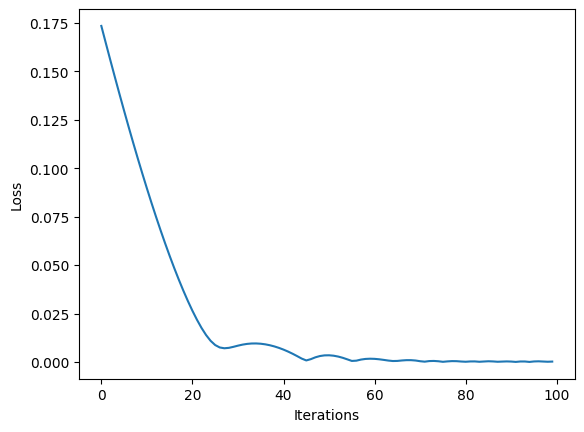

In [19]:
# 输出训练结束后的参数化量子线路
print(cir)

# 绘制损失函数随迭代次数的变化曲线
func = plt.plot(loss_list)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

我们可以发现随着训练的进行保真度距离收敛于零附近，这意味着参数化量子电路的输出态已经非常接近目标态，说明我们成功训练出了一个可以制备目标态的量子电路。